# PyFME Validation: comparing response versus Matlab model

In [36]:
from pyfme.aircrafts import LinearB747, Cessna172, SimplifiedCessna172
from pyfme.models import EulerFlatEarth
import numpy as np
# nl = np.linalg
import matplotlib.pyplot as plt
from pyfme.environment.atmosphere import SeaLevel
from pyfme.environment.wind import NoWind
from pyfme.environment.gravity import VerticalConstant
from pyfme.environment import Environment
from pyfme.utils.trimmer import steady_state_trim
from pyfme.models.state.position import EarthPosition
from pyfme.simulator import Simulation
from pyfme.utils.export import results2matlab
from scipy.io import savemat, loadmat
from pyfme.utils.coordinates import wind2body, body2wind
from pyfme.utils.input_generator import Constant, Doublet, Ramp
from json import load as jload

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Running a PyFME simulation and save it to a MATLAB readable file

We start by defining the airplane and the environment.

In [37]:
aircraft = SimplifiedCessna172()

In [38]:
atmosphere = SeaLevel()
gravity = VerticalConstant()
wind = NoWind()
environment = Environment(atmosphere, gravity, wind)

We then pick a the trim position. We save the trimmed state into a json file.

In [39]:
pos = EarthPosition(x=0, y=0, height=1000)
psi = 0.5  # rad
TAS = 45  # m/s
controls0 = {'delta_elevator': 0, 'delta_aileron': 0, 'delta_rudder': 0, 'delta_t': 0.5}
trimmed_state, trimmed_controls = steady_state_trim(
    aircraft,
    environment,
    pos,
    psi,
    TAS,
    controls0
)
environment.update(trimmed_state)

In [40]:
trimmed_state.save_to_json('ini_state.json')

We finally pick a particular time serie of controls and run the simulation.

In [41]:
controls = {
    'delta_elevator': Doublet(t_init=2, T=1, A=0.1, offset=trimmed_controls['delta_elevator']),
    'delta_aileron': Ramp(t_init=1,T=2, A=.2, offset=trimmed_controls['delta_aileron']),
    'delta_rudder': Constant(trimmed_controls['delta_rudder']),
    'delta_t': Constant(trimmed_controls['delta_t'])
}

In [42]:
environment.update(trimmed_state)
system = EulerFlatEarth(t0=0, full_state=trimmed_state)
sim = Simulation(aircraft, system, environment, controls)

In [43]:
T = 10 # seconds

In [44]:
results = sim.propagate(T)

time: 100%|████████████████████████████████████████████████████████████▉| 9.999999999999831/10 [00:06<00:00,  1.60it/s]


We save the controls in a Matlab file

In [45]:
N = int(T/sim.dt)
t=  np.arange(N)*sim.dt
controls4matlab = np.ones((N,4));
for it in range(N):
    controls4matlab[it,0] = controls['delta_aileron']._fun(t[it])
    controls4matlab[it,1] = controls['delta_elevator']._fun(t[it])
    controls4matlab[it,2] = controls['delta_rudder']._fun(t[it])
    controls4matlab[it,3] = controls['delta_t']._fun(t[it])
savemat('controls.mat',{'c': controls4matlab, 'dt':sim.dt})

# Run the same simulation in Simulink

The simulink bloc diagram used for comparison uses exactly the same model to compute forces and moments (the method aircraft.compute_forces_and_moments() was translated directly to Matlab). The entire equations of motion integration is done with the %6DOF (Quaternion) % Simulink bloc from the aerospace blocset. Verifying against this tool allows to make sure that there are no mistake in the way the EulerFlatEarth equations of motion are written, and in the way they are integrated.

We run the Simulink model and load the results:

In [48]:
with open('../matlab_comparison/matlab_results.json','r') as f:
    mat_states = jload(f)
mat_states = {k:np.array(el) for k,el in mat_states.items()}
print(f"{mat_states.keys()}")

dict_keys(['V_body', 'Omega_body', 'Euler', 't'])


# Compare outputs

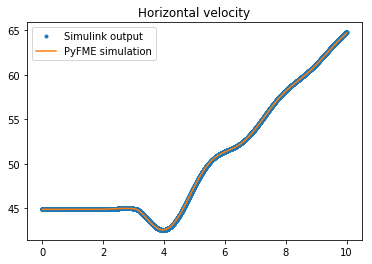

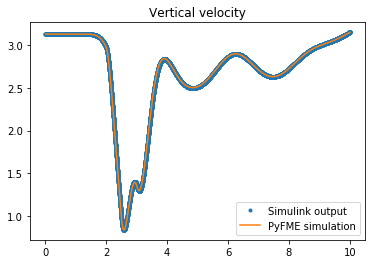

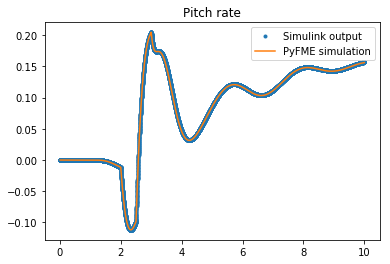

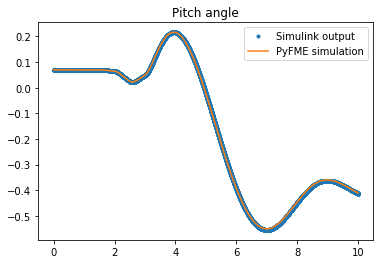

In [51]:
# Longitudinal values
plt.plot(mat_states['t'], mat_states['V_body'][:,0], '.', label='Simulink output')
plt.plot(results.u, label='PyFME simulation')
plt.legend()
plt.title("Horizontal velocity")
plt.show()

plt.plot(mat_states['t'], mat_states['V_body'][:,2], '.', label='Simulink output')
plt.plot(results.w, label='PyFME simulation')
plt.legend()
plt.title("Vertical velocity")
plt.show()

plt.plot(mat_states['t'], mat_states['Omega_body'][:,1], '.', label='Simulink output')
plt.plot(results.q, label='PyFME simulation')
plt.legend()
plt.title("Pitch rate")
plt.show()

plt.plot(mat_states['t'], mat_states['Euler'][:,1], '.', label='Simulink output')
plt.plot(results.theta, label='PyFME simulation')
plt.legend()
plt.title("Pitch angle")
plt.show()

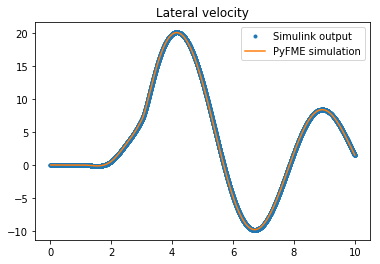

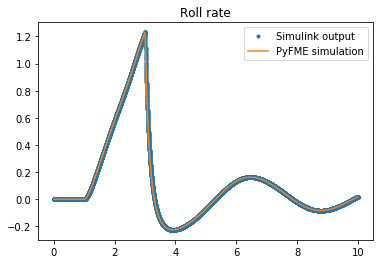

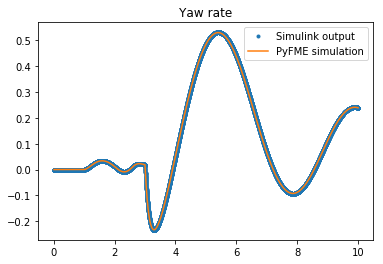

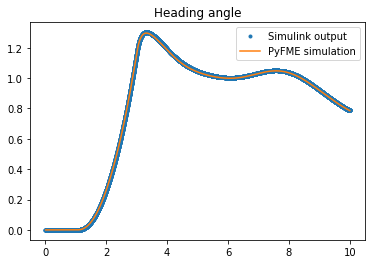

In [52]:
# Lateral case
plt.plot(mat_states['t'], mat_states['V_body'][:,1], '.', label='Simulink output')
plt.plot(results.v, label='PyFME simulation')
plt.legend()
plt.title("Lateral velocity")
plt.show()

plt.plot(mat_states['t'], mat_states['Omega_body'][:,0], '.', label='Simulink output')
plt.plot(results.p, label='PyFME simulation')
plt.legend()
plt.title("Roll rate")
plt.show()

plt.plot(mat_states['t'], mat_states['Omega_body'][:,2], '.', label='Simulink output')
plt.plot(results.r, label='PyFME simulation')
plt.legend()
plt.title("Yaw rate")
plt.show()

plt.plot(mat_states['t'], mat_states['Euler'][:,0], '.', label='Simulink output')
plt.plot(results.phi, label='PyFME simulation')
plt.legend()
plt.title("Heading angle")
plt.show()